In this notebook we will try methods inspired in the [deep docking method](https://onlinelibrary.wiley.com/doi/full/10.1002/minf.202000028) applied to the cytochromes dataset. For training and testing we will use the data set of shared compounds between isoforms 2c9 and 3a4, while the molecules that are only tested against one of the isoforms will be used as a validation dataset.

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from itertools import product
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
%load_ext tensorboard
matplotlib.rcParams.update({'font.size': 24})

PATH_DATA = "../datasets/CYP/"
N_BITS = 2048

In [2]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
validation_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_validation_2c9 = (validation_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
validation_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_validation_3a4 = (validation_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

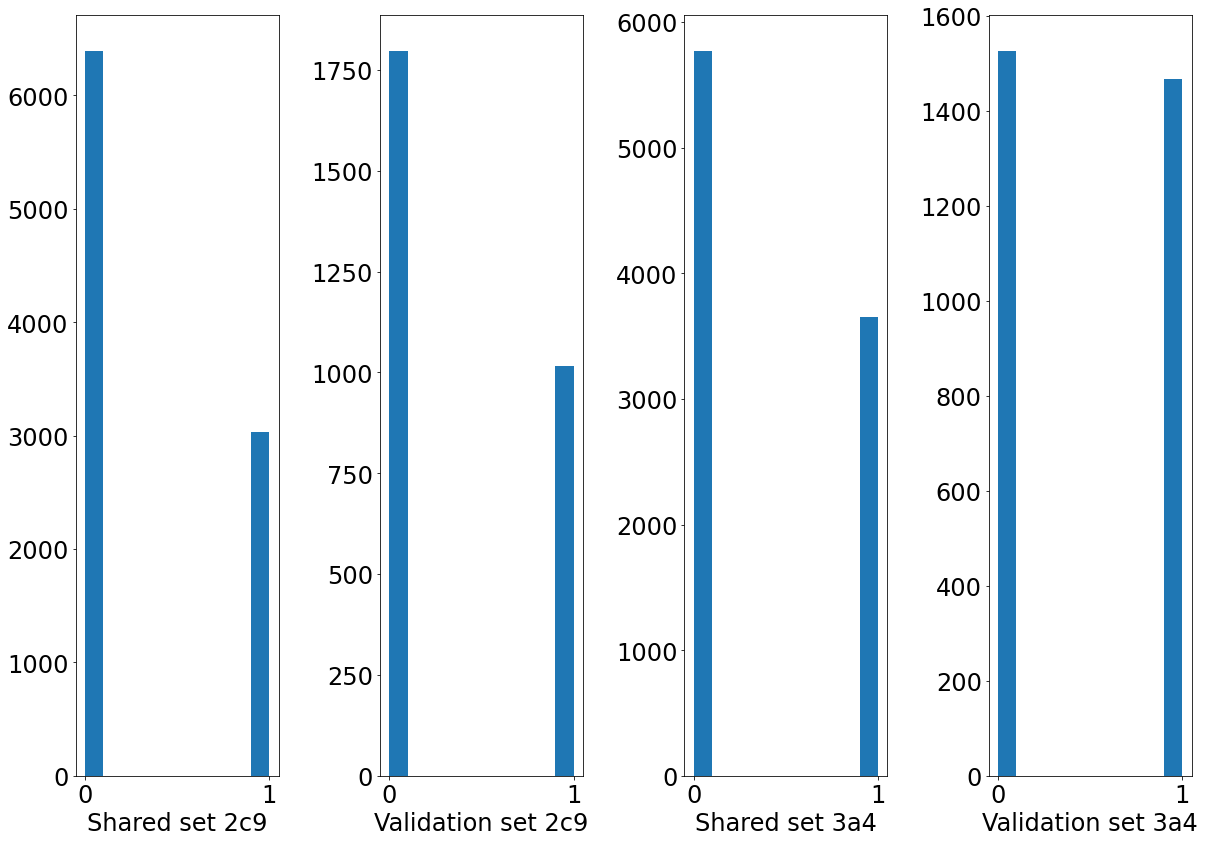

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(20,14))
ax[0].hist(labels_2c9)
ax[0].set_xlabel("Shared set 2c9")
ax[1].hist(labels_validation_2c9)
ax[1].set_xlabel("Validation set 2c9")
ax[2].hist(labels_3a4)
ax[2].set_xlabel("Shared set 3a4")
ax[3].hist(labels_validation_3a4)
ax[3].set_xlabel("Validation set 3a4")
plt.subplots_adjust(wspace=0.5)

We need to generate the features for the data sets, we will start by using the Morgan fingerprint as implemented in RDKit. The parameters are a match to those in the paper, 1024 bits and radius 2.

In [10]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=N_BITS)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

In [11]:
if os.path.exists("shared_set_features_2048_bits.npy"):
    features_shared = np.load("shared_set_features_2048_bits.npy")
else:
    features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
    np.save("shared_set_features_2048_bits.npy", features_shared)
if os.path.exists("only_2c9_set_features_2048_bits.npy"):
    features_only_2c9 = np.load("only_2c9_set_features_larger_bits.npy")
else:   
    features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set_cyp.sdf"))
    np.save("only_2c9_set_features_2048_bits.npy", features_only_2c9)
if os.path.exists("only_3a4_set_features_2048_bits.npy"):
    features_only_3a4 = np.load("only_3a4_set_features_2048_bits.npy")
else:   
    features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
    np.save("only_3a4_set_features_l2048_bits.npy", features_only_3a4)

We start fitting a model to the 2c9 isoform only, with 25% of the data to the test set, we will use the other 2c9 data set as validation.

(7065, 2048) (2355, 2048) (7065,) (2355,)


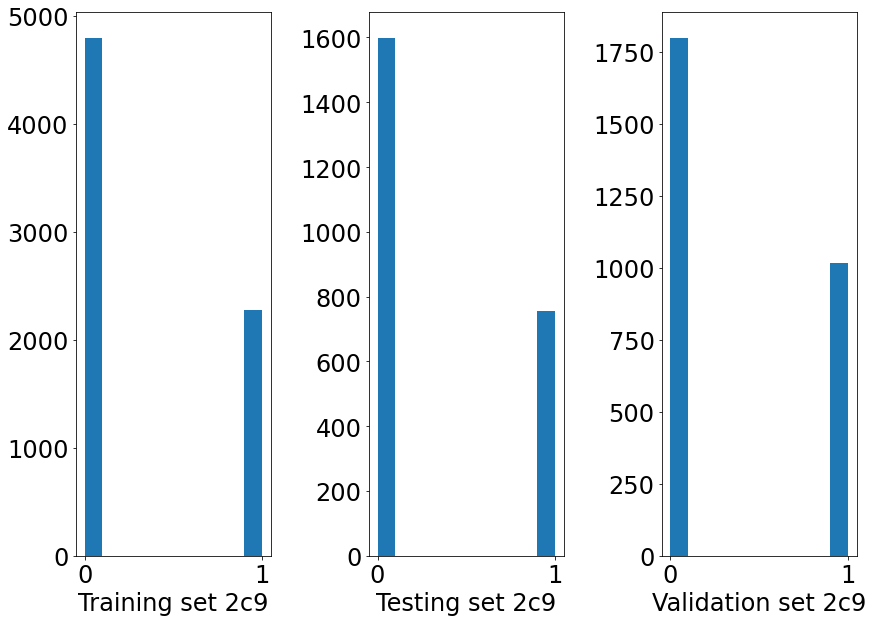

In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)
fig, ax = plt.subplots(1, 3, figsize=(14,10))
ax[0].hist(train_labels)
ax[0].set_xlabel("Training set 2c9")
ax[1].hist(test_labels)
ax[1].set_xlabel("Testing set 2c9")
ax[2].hist(labels_validation_2c9)
ax[2].set_xlabel("Validation set 2c9")
plt.subplots_adjust(wspace=0.5)

In [13]:
def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, np.round(predicted_values)).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fp)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")

In [14]:
def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, np.round(predicted_values))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])

After trying some hyperparameters, we recreate one of the high accuracy models

In [15]:
hidden_layers = 8
neurons = 256
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(N_BITS, activation='relu', input_shape=(N_BITS,)),tf.keras.layers.Dropout(dropout)]+
    [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
    [tf.keras.layers.Dense(1, activation="sigmoid")])

model.summary()
loss_function = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
history = model.fit(train_data, train_labels, epochs=10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 256)              

74/74 [==============================] - 0s 6ms/step - loss: 1.5343 - binary_accuracy: 0.8166
NER: 0.765, Sensitivity or recall: 0.620, Specificity: 0.910, Precision: 0.765, Correctly calssified: 0.870, MCC: 0.564


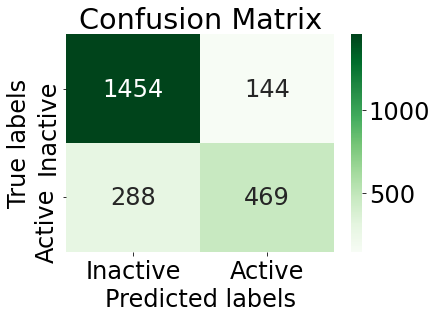

In [16]:
results = model.evaluate(test_data, test_labels)
predictions = model.predict(test_data)
# predictions = np.argmax(predictions, axis=1)
print_metrics(predictions, test_labels);
plot_confusion(predictions, test_labels);

[[0.09697387 0.00275103 0.01925722 0.00137552 0.01375516 0.00825309]
 [0.09027778 0.00694444 0.02777778 0.         0.         0.02777778]
 [0.14930556 0.00694444 0.01736111 0.00347222 0.00694444 0.01388889]
 [0.08528785 0.0021322  0.02771855 0.00426439 0.00852878 0.01279318]]


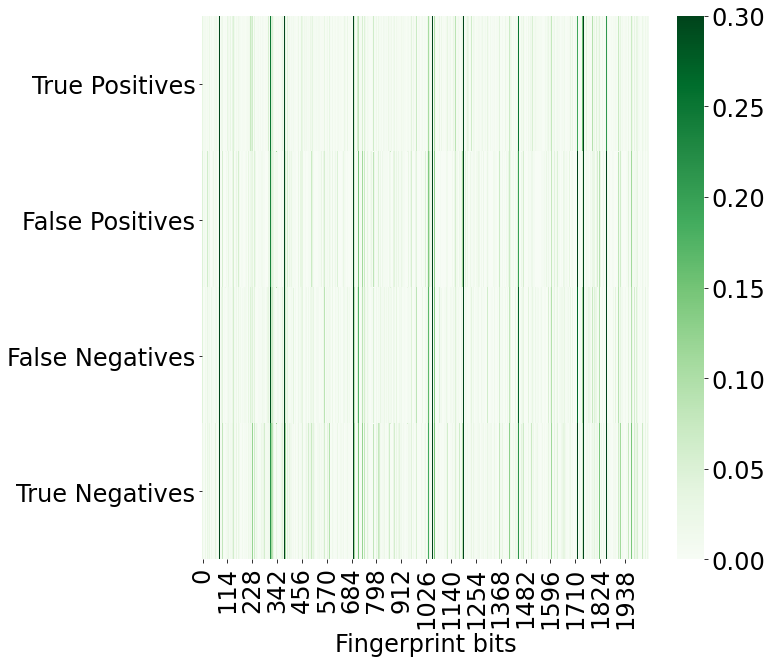

In [17]:
labels = ["True Positives", "False Positives", "False Negatives", "True Negatives"]
pred = predictions[:,0]
feature_values = np.array([np.mean(test_data[(pred<0.5) & (test_labels<0.5)], axis=0),
                  np.mean(test_data[(pred>0.5) & (test_labels<0.5)], axis=0),
                  np.mean(test_data[(pred<0.5) & (test_labels>0.5)], axis=0),
                  np.mean(test_data[(pred>0.5) & (test_labels>0.5)], axis=0)])
print(feature_values[:, 352:358])
fig, ax= plt.subplots(figsize=(10, 10))
sns.heatmap(feature_values, vmax=0.3, annot=False, ax = ax, fmt="g", cmap="Greens")
# labels, title and ticks
ax.set_xlabel('Fingerprint bits'); 
ax.set_yticklabels(labels, rotation=0);

88/88 [==============================] - 1s 7ms/step - loss: 1.7243 - binary_accuracy: 0.7608
NER: 0.714, Sensitivity or recall: 0.545, Specificity: 0.883, Precision: 0.724, Correctly calssified: 0.835, MCC: 0.462


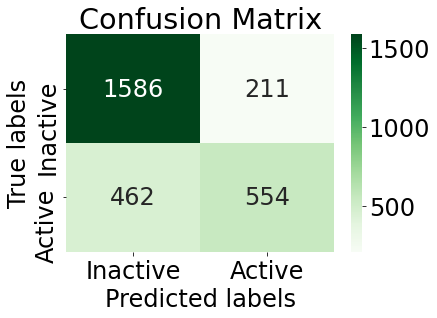

In [18]:
results = model.evaluate(features_only_2c9, labels_validation_2c9)
predictions = model.predict(features_only_2c9)
print_metrics(predictions, labels_validation_2c9);
plot_confusion(predictions, labels_validation_2c9);

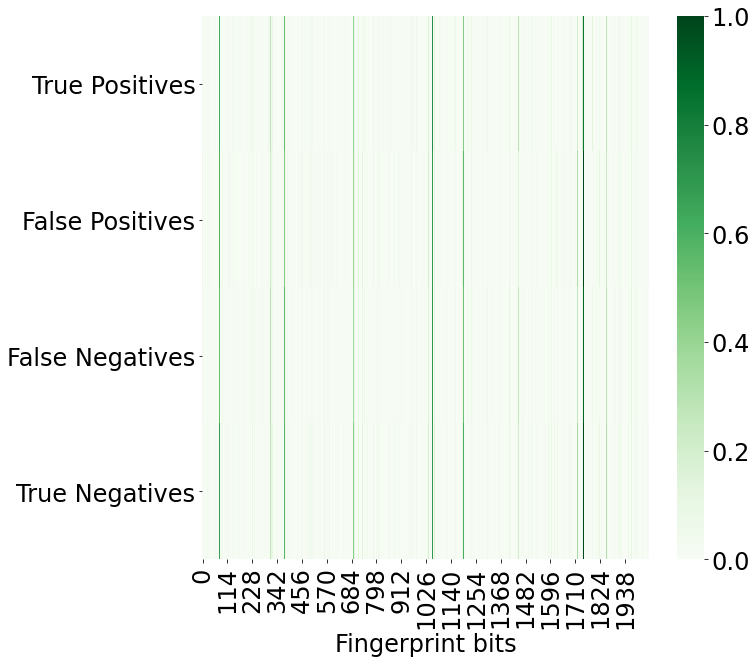

In [20]:
labels = ["True Positives", "False Positives", "False Negatives", "True Negatives"]
pred = predictions[:,0]
feature_values = np.array([np.mean(features_only_2c9[(pred<0.5) & (labels_validation_2c9<0.5)], axis=0),
                  np.mean(features_only_2c9[(pred>0.5) & (labels_validation_2c9<0.5)], axis=0),
                  np.mean(features_only_2c9[(pred<0.5) & (labels_validation_2c9>0.5)], axis=0),
                  np.mean(features_only_2c9[(pred>0.5) & (labels_validation_2c9>0.5)], axis=0)])
fig, ax= plt.subplots(figsize=(10, 10))
sns.heatmap(feature_values, annot=False, ax = ax, fmt="g", cmap="Greens")
# labels, title and ticks
ax.set_xlabel('Fingerprint bits'); 
ax.set_yticklabels(labels, rotation=0);

And we do the same for 3a4

(7065, 2048) (2355, 2048) (7065,) (2355,)


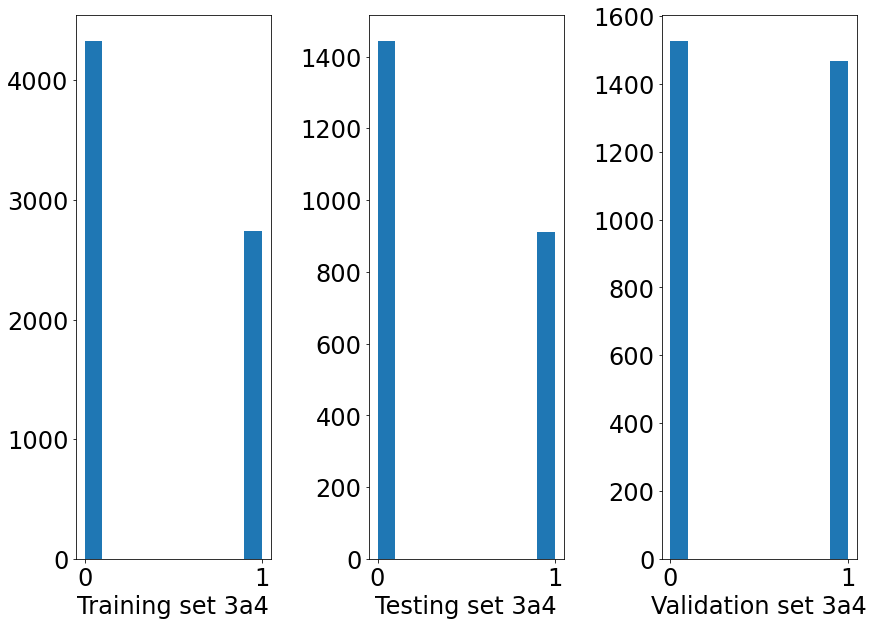

In [21]:
train_data_3a4, test_data_3a4, train_labels_3a4, test_labels_3a4 = train_test_split(features_shared, labels_3a4, stratify=labels_3a4)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)
fig, ax = plt.subplots(1, 3, figsize=(14,10))
ax[0].hist(train_labels_3a4)
ax[0].set_xlabel("Training set 3a4")
ax[1].hist(test_labels_3a4)
ax[1].set_xlabel("Testing set 3a4")
ax[2].hist(labels_validation_3a4)
ax[2].set_xlabel("Validation set 3a4")
plt.subplots_adjust(wspace=0.5)

In [22]:
hidden_layers = 8
neurons = 256
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(N_BITS, activation='relu', input_shape=(N_BITS,)),tf.keras.layers.Dropout(dropout)]+
    [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
    [tf.keras.layers.Dense(1, activation="sigmoid")])

model.summary()
loss_function = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
history = model.fit(train_data_3a4, train_labels_3a4, epochs=10)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_25 (Dense)             (None, 256)              

74/74 [==============================] - 0s 5ms/step - loss: 1.5646 - binary_accuracy: 0.8140
NER: 0.793, Sensitivity or recall: 0.698, Specificity: 0.887, Precision: 0.796, Correctly calssified: 0.855, MCC: 0.602


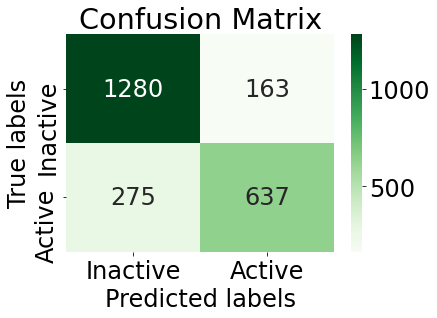

In [23]:
results = model.evaluate(test_data_3a4, test_labels_3a4)
predictions = model.predict(test_data_3a4)
# predictions = np.argmax(predictions, axis=1)
print_metrics(predictions, test_labels_3a4);
plot_confusion(predictions, test_labels_3a4);

94/94 [==============================] - 1s 5ms/step - loss: 1.8444 - binary_accuracy: 0.7388
NER: 0.737, Sensitivity or recall: 0.642, Specificity: 0.832, Precision: 0.786, Correctly calssified: 0.812, MCC: 0.484


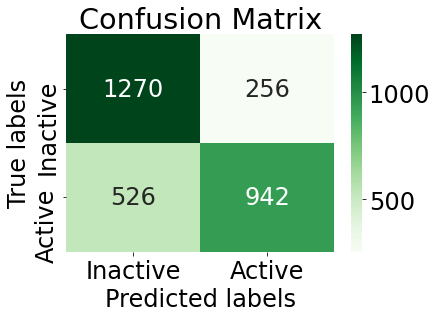

In [24]:
results = model.evaluate(features_only_3a4, labels_validation_3a4)
predictions = model.predict(features_only_3a4)
print_metrics(predictions, labels_validation_3a4);
plot_confusion(predictions, labels_validation_3a4);